# Evaluate DQN model


## Import dependecies and recheck installation

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
import pprint;
import pandas as pd
import os
import json
from copy import deepcopy
from collections import deque
from IPython.display import display, clear_output, HTML

print("All dependencies imported successfully.")
print("torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("CUDA not available. Using CPU. Why????")


All dependencies imported successfully.
torch version: 2.5.1
CUDA available: True
CUDA version: 11.8
GPU name: NVIDIA GeForce RTX 4090


### Fixed Random seeds

In [2]:
SEED = 666
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(SEED)

In [3]:
LOG_DIR ="Logs/DQN/"
MODEL_DIR ="Models/DQN/"
PLOTS = "Plots/DQN/"

## My imports

In [4]:
from C4.connect4_env import Connect4Env
from C4.fast_connect4_lookahead import Connect4Lookahead
#from C4.connect4_lookahead import Connect4Lookahead
from DQN.training_phases_config import TRAINING_PHASES
from DQN.opponent_action import get_opponent_action
from DQN.DQN_replay_memory_per import PrioritizedReplayMemory
from DQN.dqn_model import DQN
from DQN.dqn_agent import DQNAgent
from DQN.dqn_utilities import *
from C4.plot_phase_summary import plot_phase_summary
from DQN.nstep_buffer import NStepBuffer
from DQN.eval_utilities import evaluate_agent_model, log_phase_evaluation
from C4.connect4_board_display import display_final_boards
from DQN.TD_error import *
from DQN.c4_seed_from_moves import seed_from_dataframe_moves
from DQN.c4_seed_util import seed_from_dataframe

Lookahead = Connect4Lookahead()

print("All custom ependencies imported successfully.")

All custom ependencies imported successfully.


In [5]:
model_name = "L1CONT I"      # evaluating

tag = f"EVAL - {model_name}"
begin_start_time = time.time()
time_str = time.strftime('%Y-%m-%d %H-%M-%S', time.localtime(begin_start_time))
TRAINING_SESSION = f"{tag}--at-{time_str}"

print("Started evaluation session", TRAINING_SESSION)

Started evaluation session EVAL - L1CONT I--at-2025-10-19 08-30-49


#### Loading checkpoint model

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", device)

using device: cuda


In [7]:
env = Connect4Env()
agent = DQNAgent(device=device)  # Fresh agent 
model_name=f"{model_name} DQN model.pt"
state_dict = torch.load(model_name, map_location=device, weights_only=True)
agent.model.load_state_dict(state_dict)
agent.update_target_model()
agent.epsilon = 0.0  
print(f"✅ {model_name} loaded and ready for further training.")

✅ L1CONT I DQN model.pt loaded and ready for further training.


# Evaluation

In [8]:
# === Pure-model evaluation ===
evaluation_opponents = {
     "Random": 203,
    "Lookahead-1": 101,
    "Lookahead-2": 53,
    "Lookahead-3": 49,
    "Lookahead-4": 37,
}
env.reset()
evaluation_results = evaluate_agent_model(agent, env, evaluation_opponents, device, Lookahead)

Opponent: Random:   0%|          | 0/203 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/101 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/53 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/49 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/37 [00:00<?, ?it/s]


📊 Evaluation Summary:
Random: 169W / 34L / 0D → Win: 83.3%, Loss: 16.7%, Draw: 0.0%
Lookahead-1: 0W / 101L / 0D → Win: 0.0%, Loss: 100.0%, Draw: 0.0%
Lookahead-2: 7W / 44L / 2D → Win: 13.2%, Loss: 83.0%, Draw: 3.8%
Lookahead-3: 0W / 49L / 0D → Win: 0.0%, Loss: 100.0%, Draw: 0.0%
Lookahead-4: 0W / 35L / 2D → Win: 0.0%, Loss: 94.6%, Draw: 5.4%
📊 Plot saved to Plots/DQN/DQN-EVAL - L1CONT I--at-2025-10-19 08-30-49-evaluation_plot.png


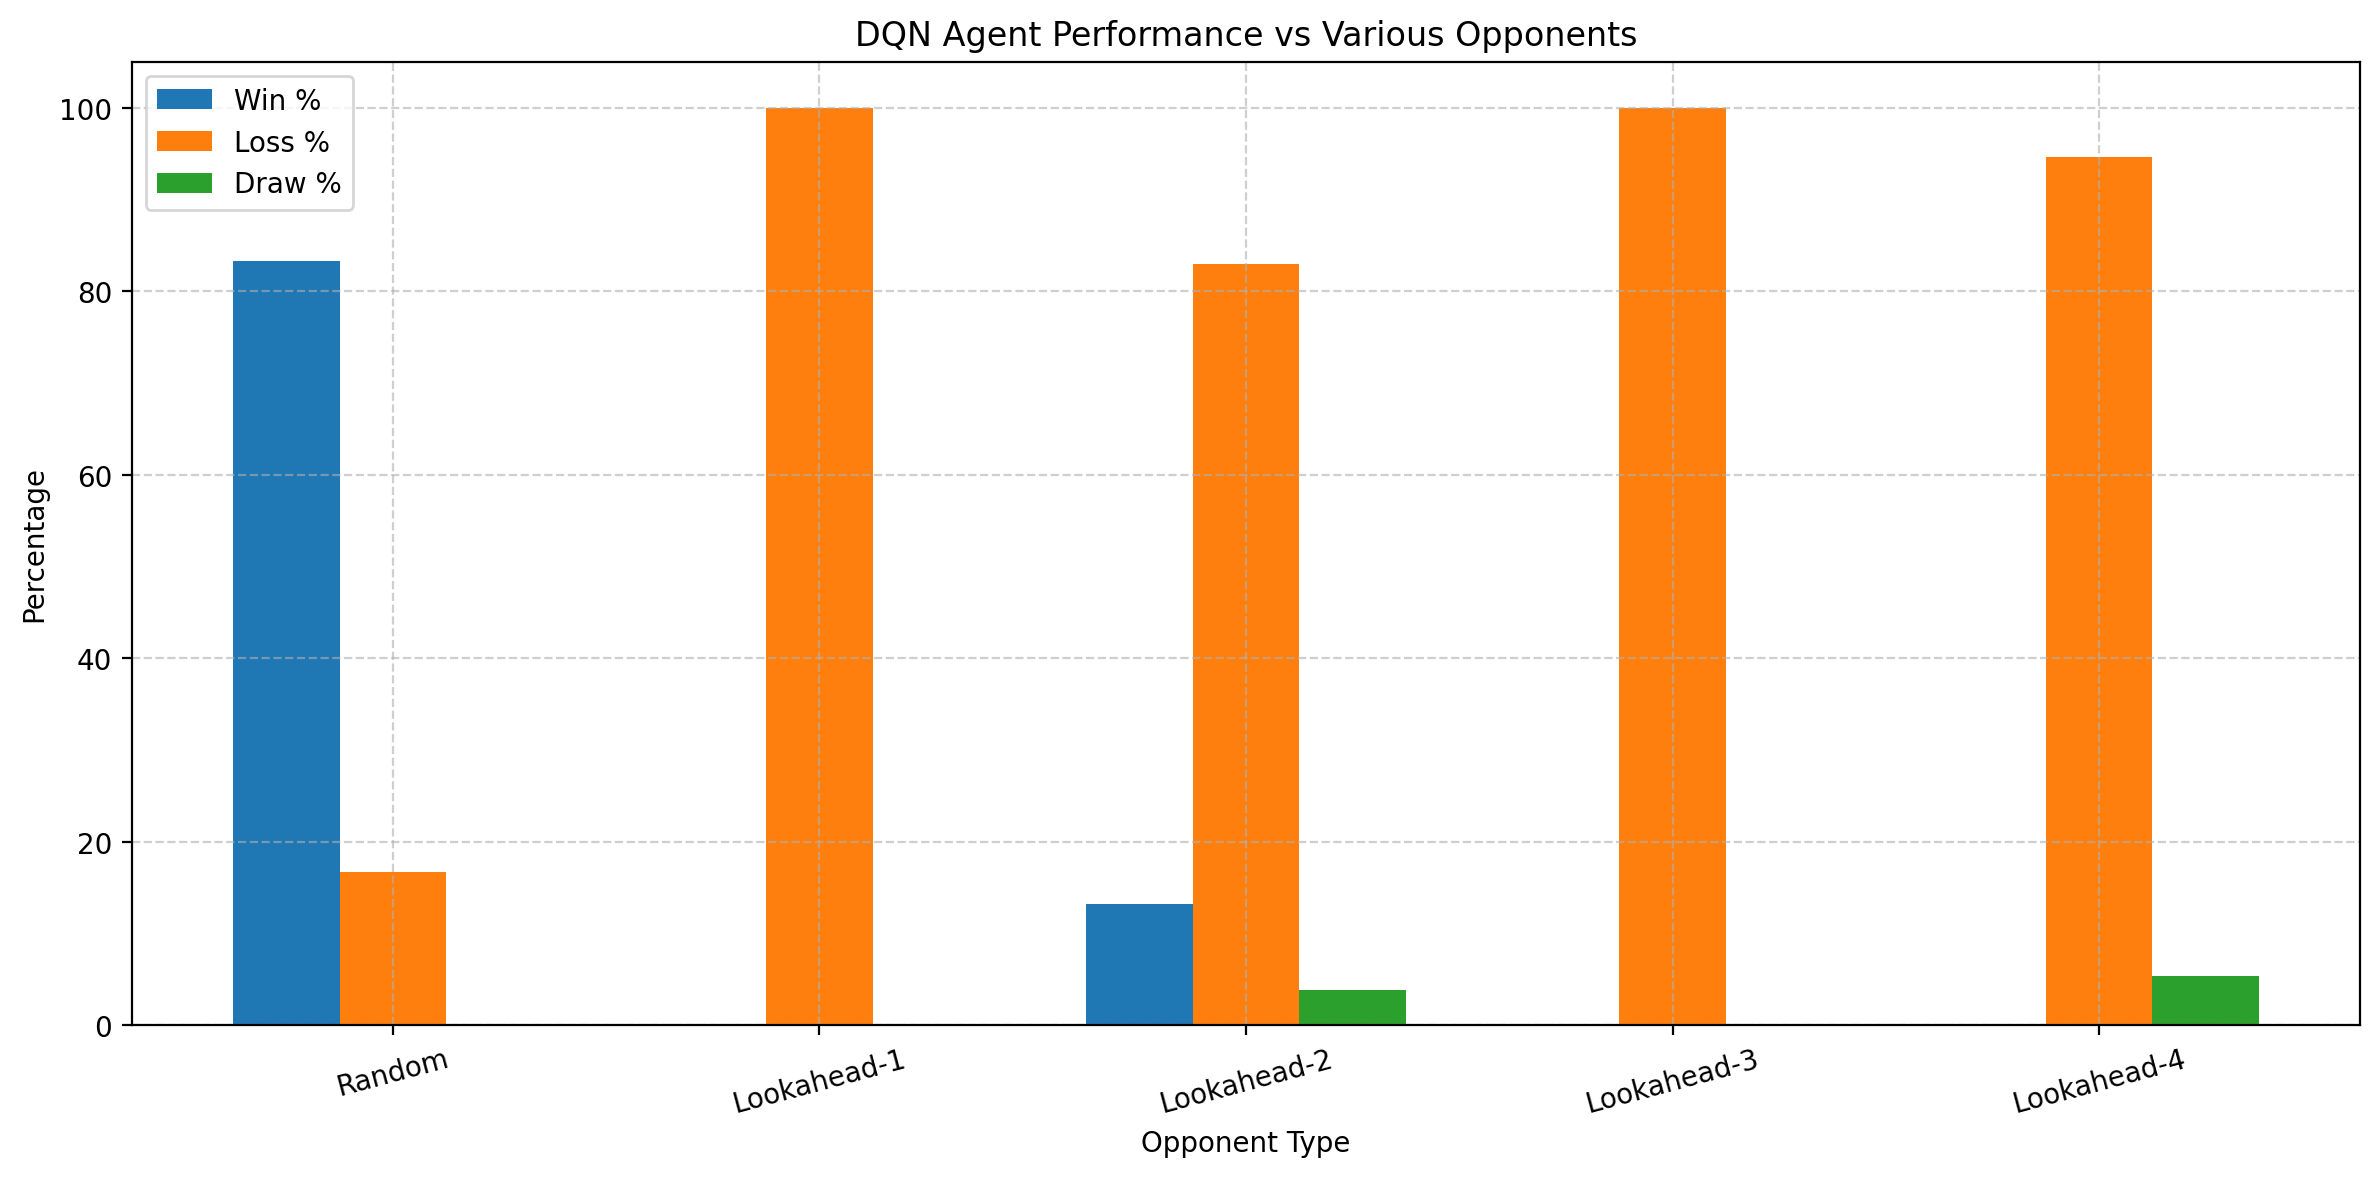

In [9]:
# === Print Summary ===
print("\n📊 Evaluation Summary:")
for label, stats in evaluation_results.items():
    print(f"{label}: {stats['wins']}W / {stats['losses']}L / {stats['draws']}D → "
          f"Win: {stats['win_rate']*100:.1f}%, Loss: {stats['loss_rate']*100:.1f}%, Draw: {stats['draw_rate']*100:.1f}%")

# === Bar Plot Summary ===
labels = list(evaluation_results.keys())
win_rates  = [evaluation_results[k]['win_rate']  * 100 for k in labels]
loss_rates = [evaluation_results[k]['loss_rate'] * 100 for k in labels]
draw_rates = [evaluation_results[k]['draw_rate'] * 100 for k in labels]

x = range(len(labels))
bar_width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x, win_rates, width=bar_width, label='Win %')
plt.bar([i + bar_width for i in x], loss_rates, width=bar_width, label='Loss %')
plt.bar([i + 2 * bar_width for i in x], draw_rates, width=bar_width, label='Draw %')
plt.xlabel('Opponent Type')
plt.ylabel('Percentage')
plt.title('DQN Agent Performance vs Various Opponents')
plt.xticks([i + bar_width for i in x], labels, rotation=15)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plot_path = f"{PLOTS}DQN-{TRAINING_SESSION}-evaluation_plot.png"
plt.savefig(plot_path, dpi=150)
print(f"📊 Plot saved to {plot_path}")

plt.show()

# Save results
df_eval = pd.DataFrame.from_dict(evaluation_results, orient='index')
df_eval.index.name = "Opponent"
# Use Excel if available; otherwise fall back to CSV
try:
    df_eval.to_excel(f"{LOG_DIR}DQN-{TRAINING_SESSION}-evaluation_results.xlsx", index=True)
except Exception as e:
    print("Excel export failed, saving CSV instead:", e)
    df_eval.to_csv(f"{LOG_DIR}DQN-{TRAINING_SESSION}-evaluation_results.csv", index=True)


### Boards


🎯 Opponent: Random


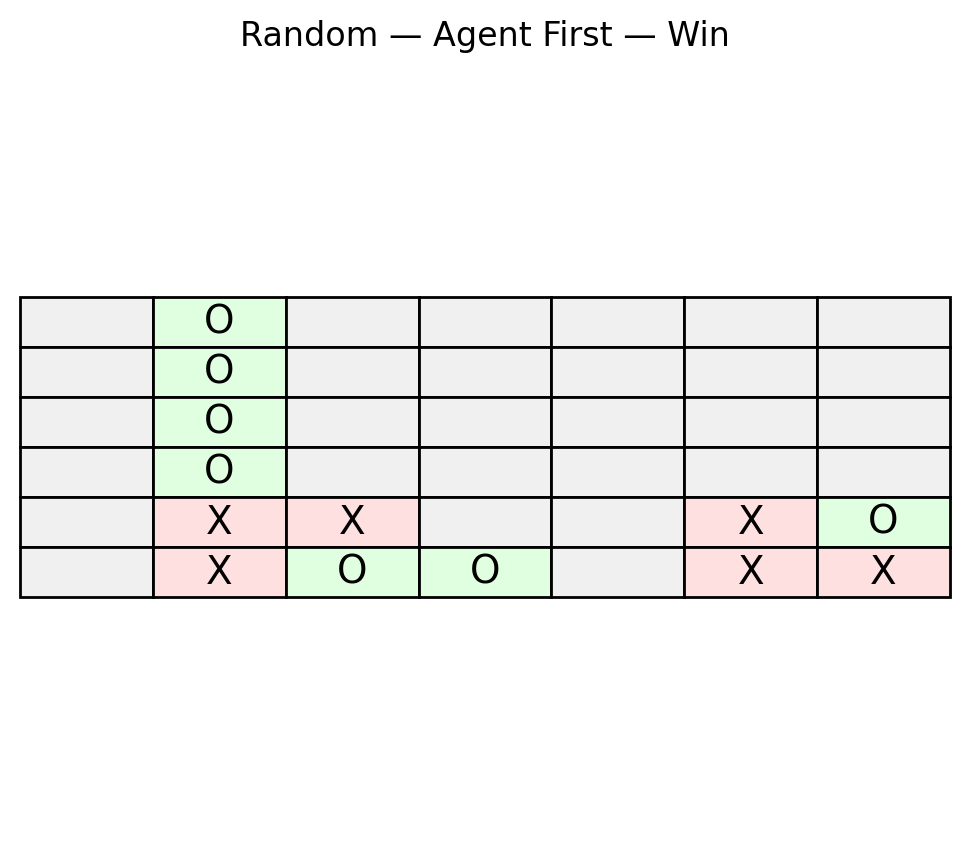

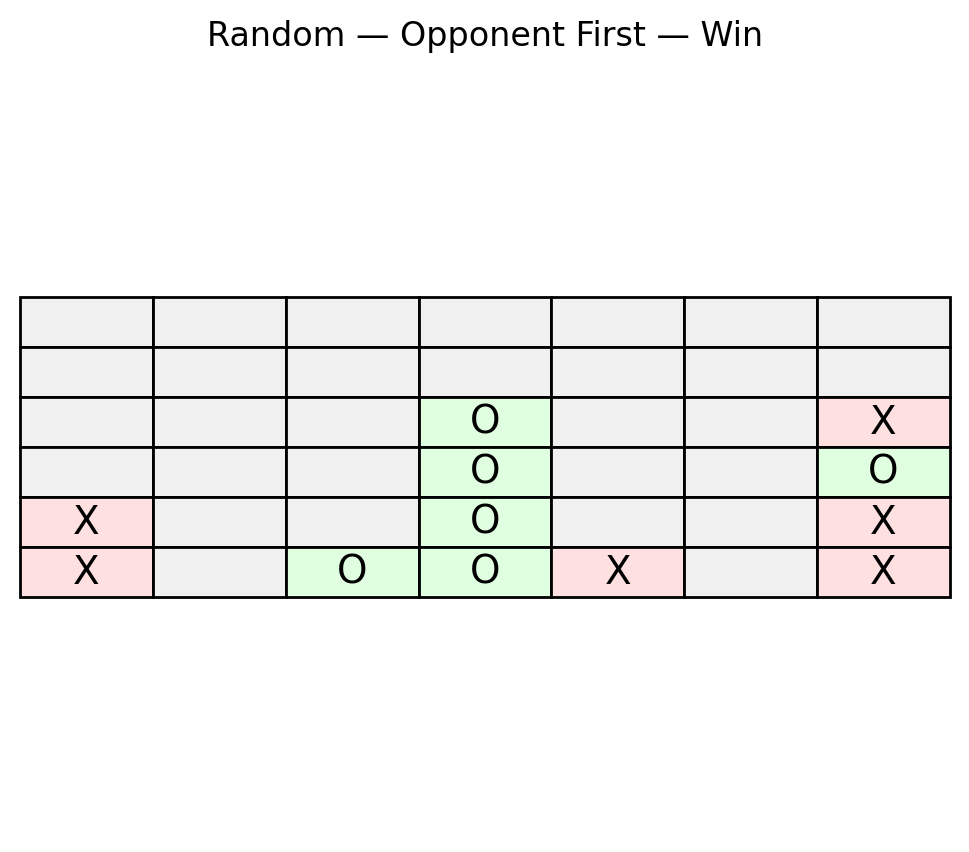

In [10]:
display_final_boards(agent, env, device, Lookahead, ["Random"])


🎯 Opponent: Lookahead-1


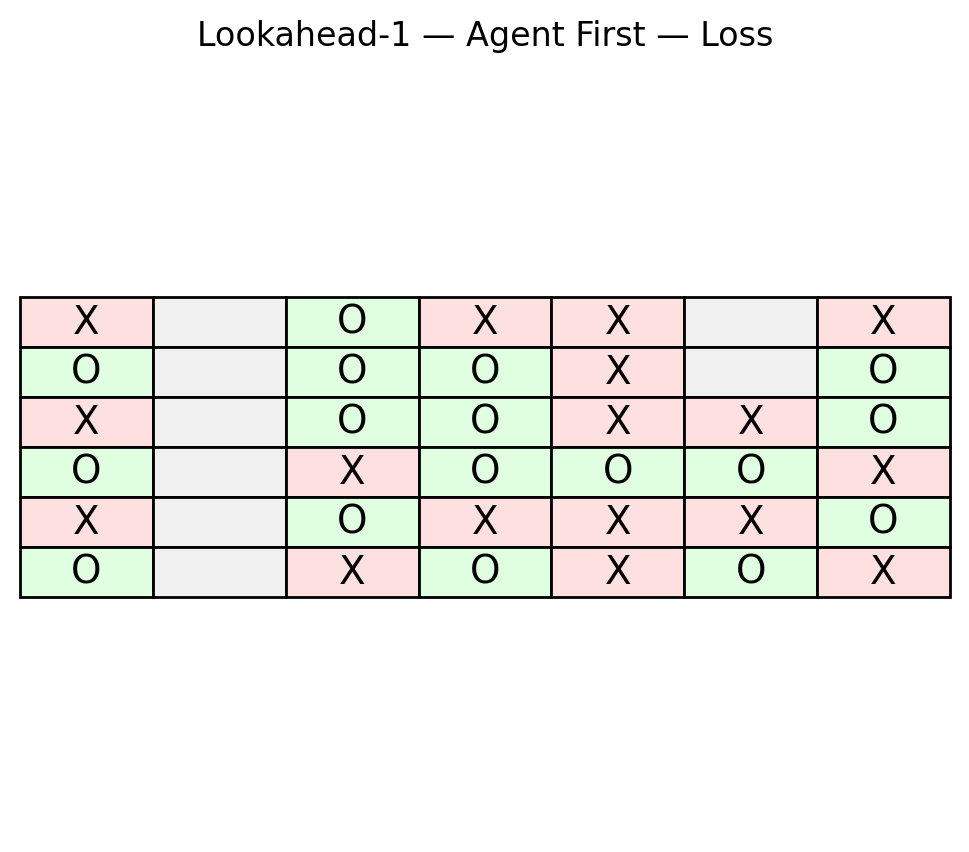

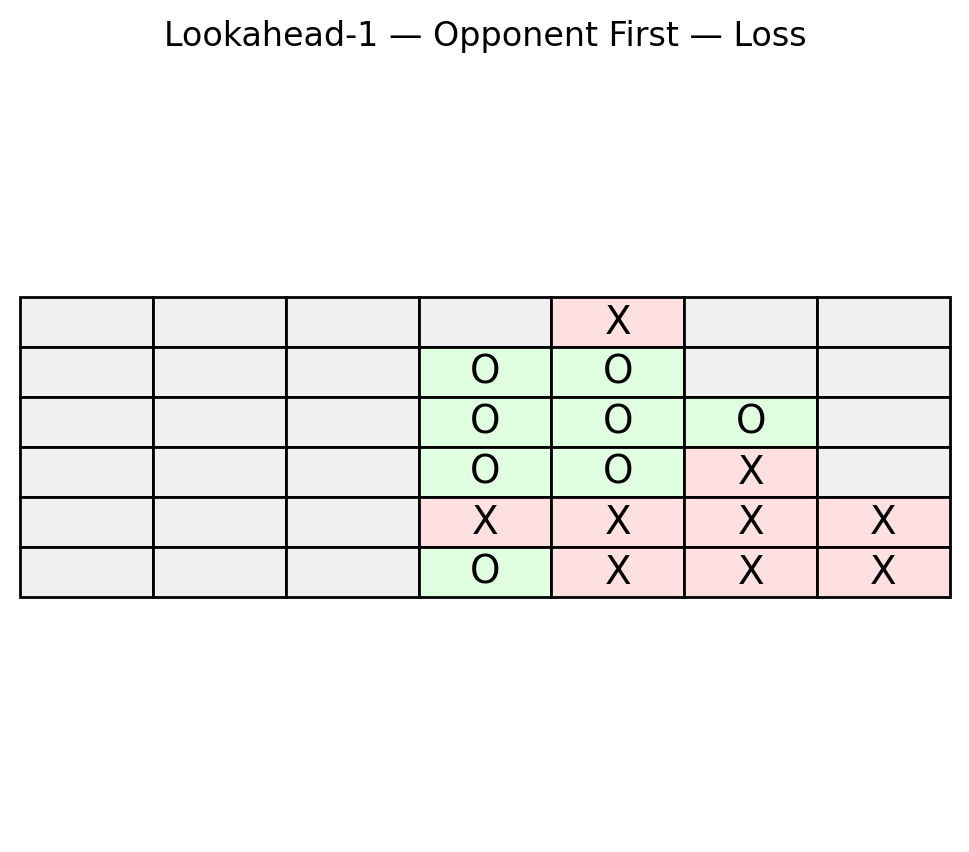

In [11]:
display_final_boards(agent, env, device, Lookahead, ["Lookahead-1"])


🎯 Opponent: Lookahead-2


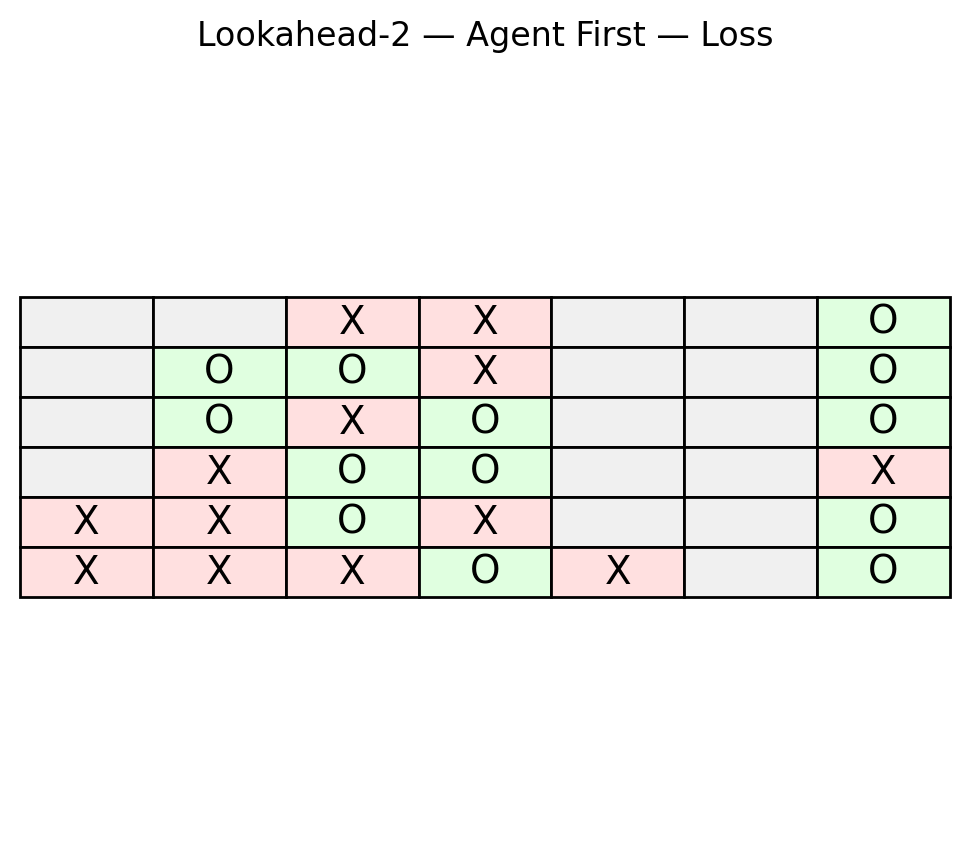

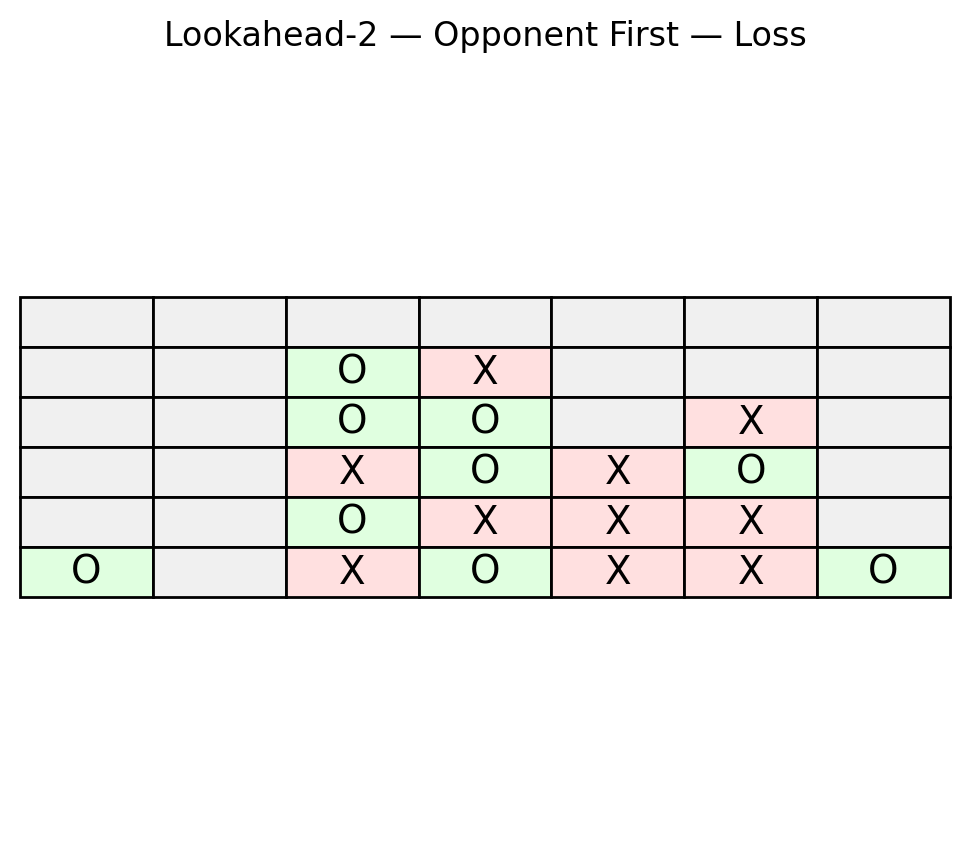

In [12]:
display_final_boards(agent, env, device, Lookahead, ["Lookahead-2"])


🎯 Opponent: Lookahead-3


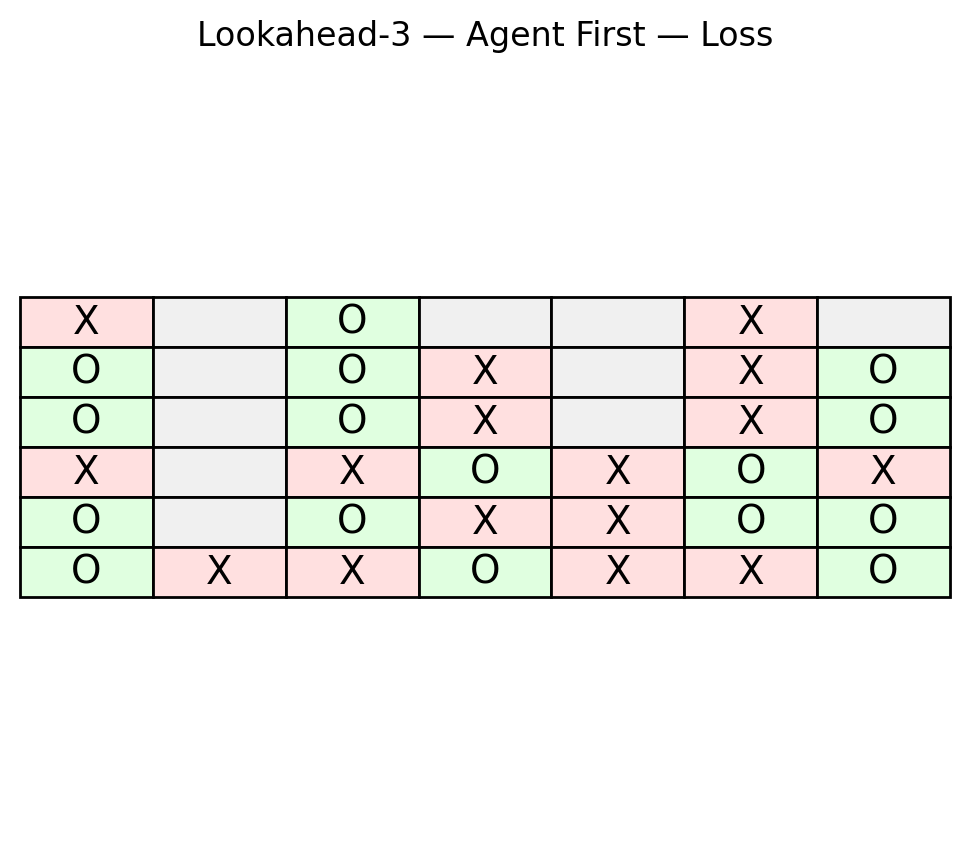

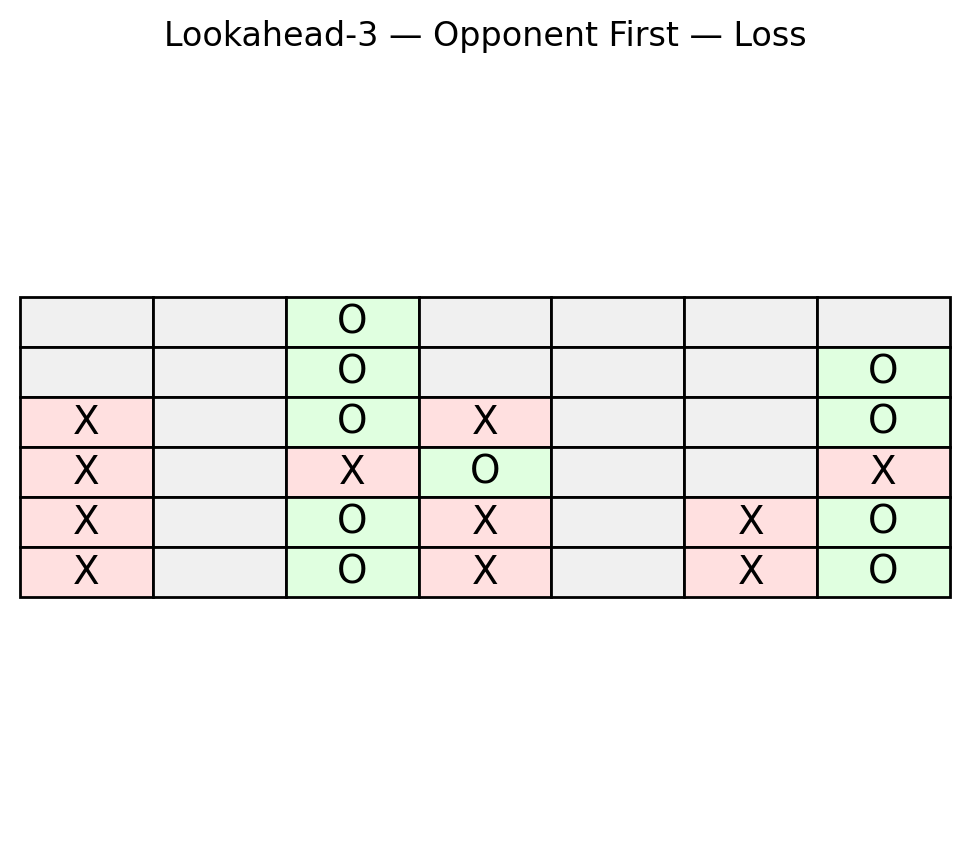

In [13]:
display_final_boards(agent, env, device, Lookahead, ["Lookahead-3"])


🎯 Opponent: Lookahead-4


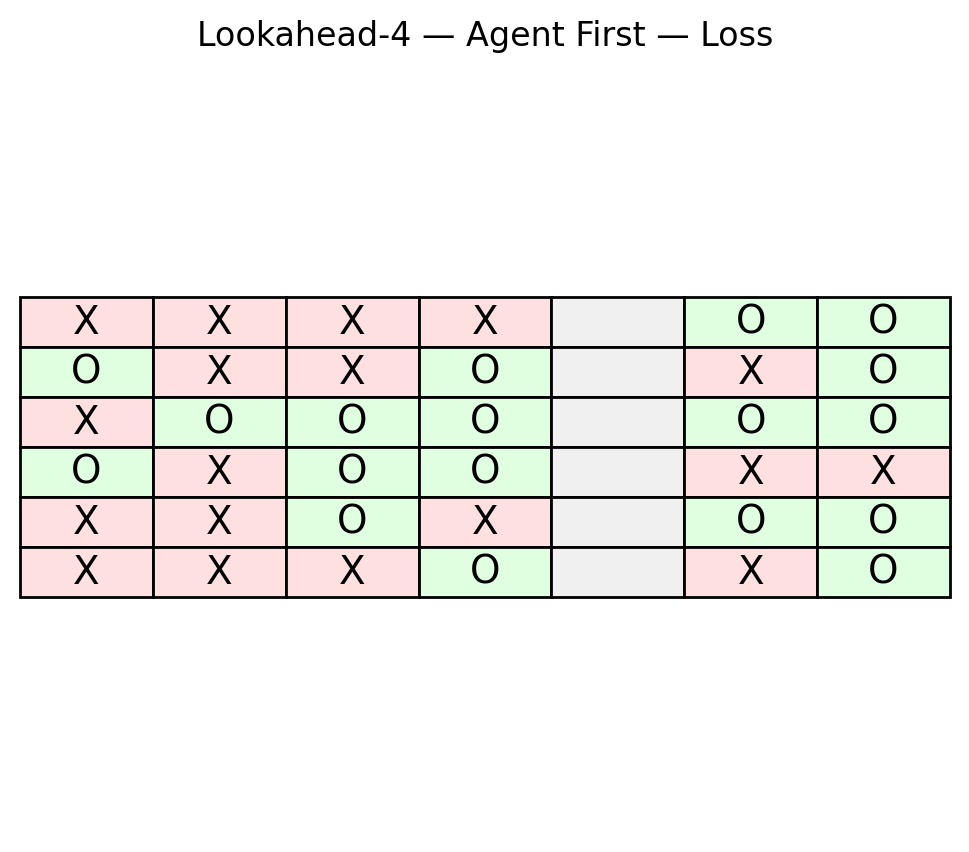

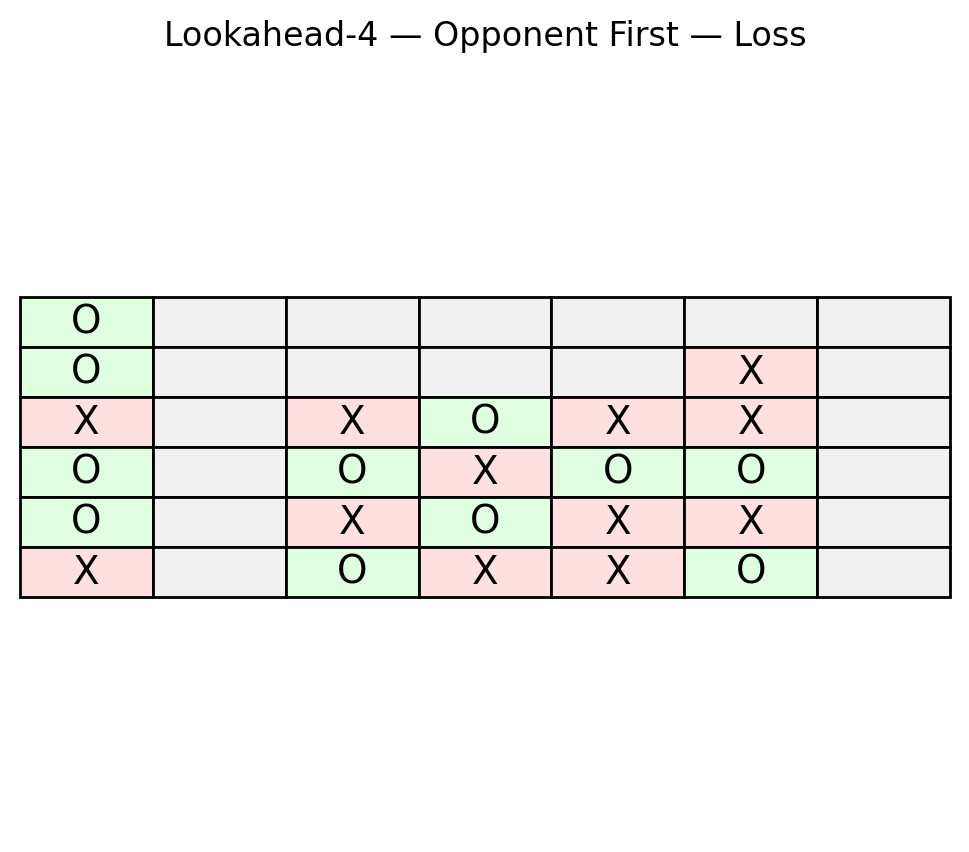

In [14]:
display_final_boards(agent, env, device, Lookahead, ["Lookahead-4"])

# DONE

In [15]:
total_end_time = time.time()
total_elapsed = (total_end_time - begin_start_time) / 3600
print(f"Evaluation completed in {total_elapsed:.1f} hours")

Evaluation completed in 0.0 hours


## Training log

In [16]:
# TRAINING_SESSION

training_log_file = "DQN training_sessions.xlsx"
log_row = {"TRAINING_SESSION": TRAINING_SESSION, "TIME [h]": total_elapsed, "EPISODES": 0}

for label, stats in evaluation_results.items():
    log_row[label] = stats["win_rate"]

# === Load or Create Excel File ===
if os.path.exists(training_log_file):
    df_log = pd.read_excel(training_log_file)
else:
    df_log = pd.DataFrame()

# === Append and Save ===
df_log = pd.concat([df_log, pd.DataFrame([log_row])], ignore_index=True)
df_log.to_excel(training_log_file, index=False)

print(f"\n📁 Training session logged to: {training_log_file}")


📁 Training session logged to: DQN training_sessions.xlsx
